# load packages and see versions

In [1]:
import matplotlib
import numpy
import PIL  # Pillow is imported as PIL
import os
os.environ["GLOG_minloglevel"] = "2"
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import platform

In [2]:
# Collect versions
package_versions = {
    "Python": platform.python_version(),
    "matplotlib": matplotlib.__version__,  # correct
    "mediapipe": mp.__version__,
    "opencv": cv2.__version__,
    "NumPy:": np.__version__,
    "Pillow:": PIL.__version__}

# Print nicely
print("Packages and Versions:")
for pkg, ver in package_versions.items():
    print(f"{pkg}: {ver}")

Packages and Versions:
Python: 3.9.25
matplotlib: 3.9.4
mediapipe: 0.10.21
opencv: 4.11.0
NumPy:: 1.26.4
Pillow:: 11.3.0


# load image and detect face with mediapipe

In [3]:
frame = plt.imread("doss/image.jpg")
#frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w, _ = frame.shape

In [7]:
# ---- MediaPipe Tasks setup ----
model_path = "face_land/face_landmarker.task"
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE, num_faces=1)
landmarker = FaceLandmarker.create_from_options(options)
# ---- Convert to MediaPipe Image ----
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
# ---- Detect landmarks ----
result = landmarker.detect(mp_image)

I0000 00:00:1770214111.649672  183490 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1770214111.651087  183600 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 17.0.6, DRM 3.57, 6.8.0-90-generic)
W0000 00:00:1770214111.651480  183490 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1770214111.657365  183602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770214111.683154  183606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


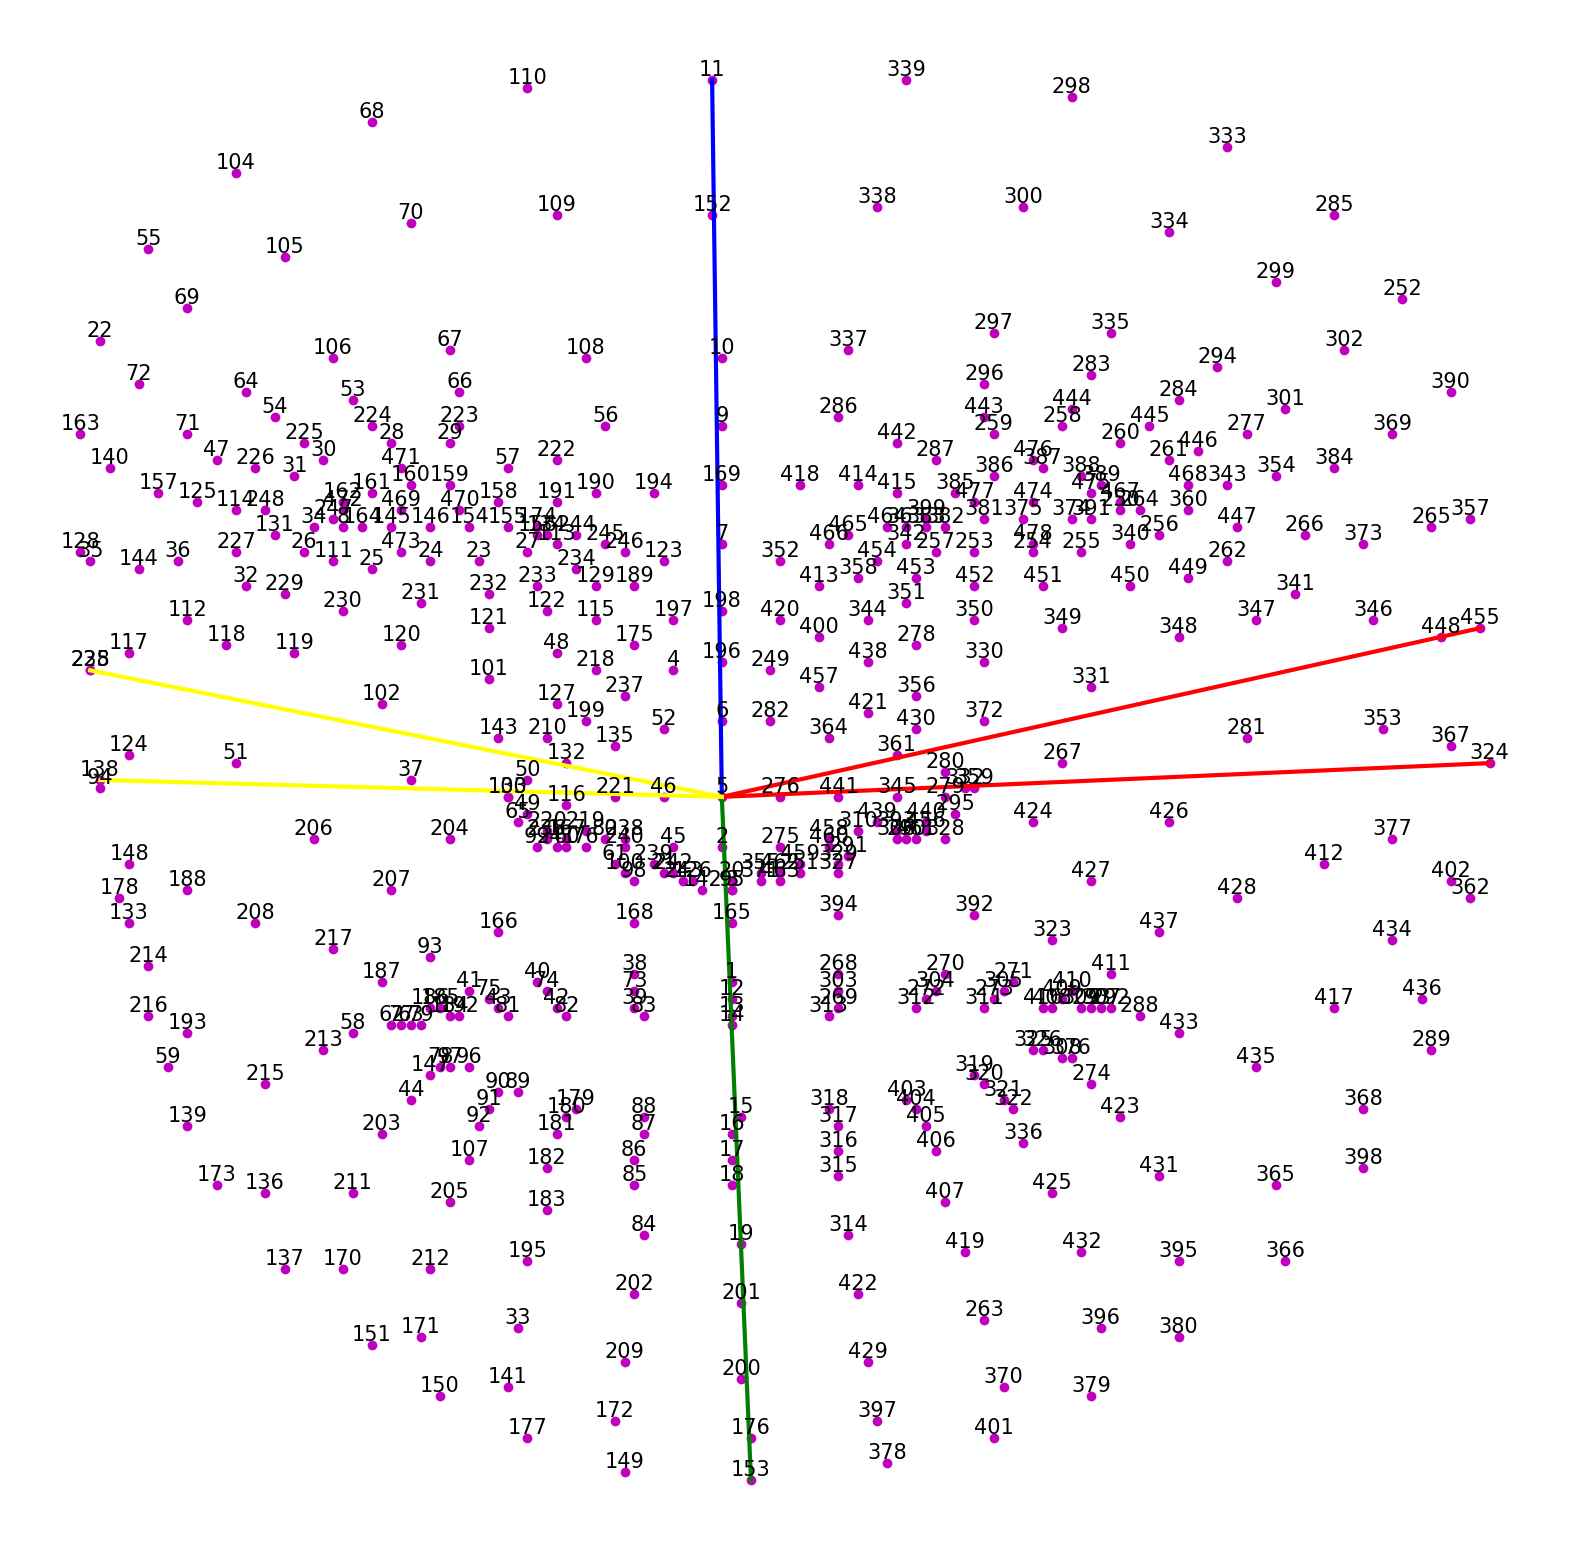

In [8]:
# ---- Extract landmarks ----
x1, y1 = [], []
if result.face_landmarks:
    face_landmarks = result.face_landmarks[0]  # first detected face
    for lm in face_landmarks:
        x1.append(int(lm.x * w))
        y1.append(int(-lm.y * h))
x1 = np.array(x1)
y1 = np.array(y1)
# ---- Plot landmarks (your exact logic) ----
plt.figure(figsize=(20, 20))
for i, (a, b) in enumerate(zip(x1, y1)):
    plt.scatter(a, b, color='m')
    plt.text(a, b, str(i + 1), fontsize=15, ha='center', va='bottom')
plt.plot([x1[10], x1[4]], [y1[10], y1[4]], color='blue', linewidth=3)
plt.plot([x1[152], x1[4]], [y1[152], y1[4]], color='green', linewidth=3)
plt.plot([x1[4], x1[454]], [y1[4], y1[454]], color='red', linewidth=3)
plt.plot([x1[4], x1[323]], [y1[4], y1[323]], color='red', linewidth=3)
plt.plot([x1[4], x1[234]], [y1[4], y1[234]], color='yellow', linewidth=3)
plt.plot([x1[4], x1[137]], [y1[4], y1[137]], color='yellow', linewidth=3)
plt.axis("off")
plt.show()
#landmarker.close()

# detect pupils and eyes corners

In [14]:
# ---- Extract landmarks ----
face_landmarks = result.face_landmarks[0]
pts = np.array([
    (int(lm.x * w), int(lm.y * h))
    for lm in face_landmarks])
x = pts[:, 0]
y = pts[:, 1]
# ---- Extreme points ----
left_pt   = pts[np.argmin(x)]
right_pt  = pts[np.argmax(x)]
top_pt    = pts[np.argmin(y)]
bottom_pt = pts[np.argmax(y)]
# ---- Eye corners ----
eye_corners = {
    "L_outer": pts[33],
    "L_inner": pts[133],
    "R_inner": pts[362],
    "R_outer": pts[263]}
# ---- Iris centers ----
left_iris_idx  = [468, 469, 470, 471]
right_iris_idx = [472, 473, 474, 475]

left_iris  = pts[left_iris_idx].mean(axis=0)
right_iris = pts[right_iris_idx].mean(axis=0)

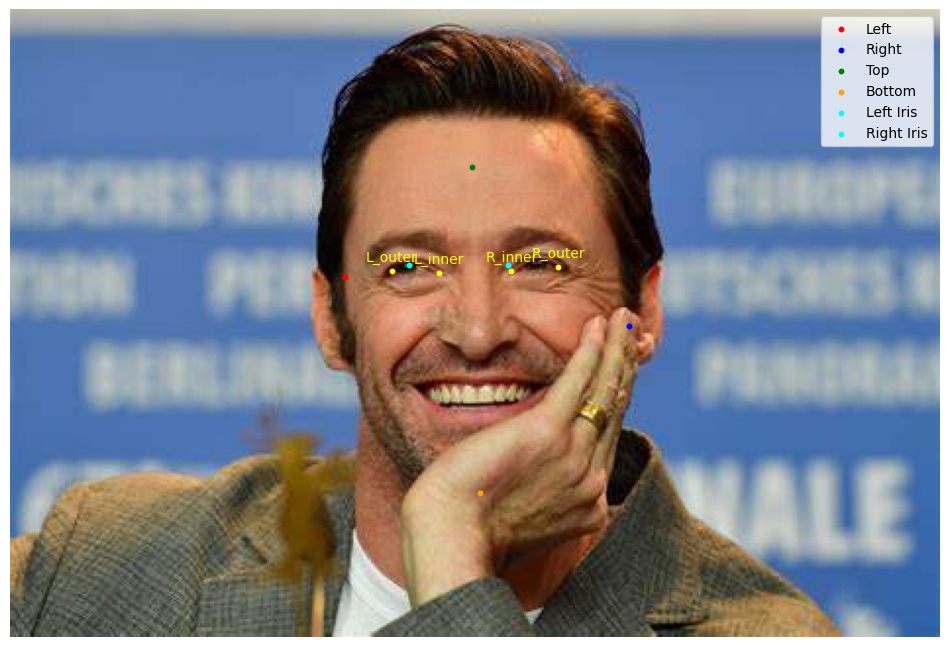

In [15]:
# ---- Plot ----
plt.figure(figsize=(12, 12))
plt.imshow(frame)
plt.axis("off")
# Face extremes
plt.scatter(*left_pt,   c='red',   s=10, label='Left')
plt.scatter(*right_pt,  c='blue',  s=10, label='Right')
plt.scatter(*top_pt,    c='green', s=10, label='Top')
plt.scatter(*bottom_pt, c='orange',s=10, label='Bottom')
# Eye corners
for name, pt in eye_corners.items():
    plt.scatter(pt[0], pt[1], c='yellow', s=10)
    plt.text(pt[0], pt[1]-5, name, color='yellow', ha='center')
# Iris centers
plt.scatter(left_iris[0], left_iris[1],  c='cyan', s=10, label='Left Iris')
plt.scatter(right_iris[0], right_iris[1], c='cyan', s=10, label='Right Iris')
plt.legend()
plt.show()

--------

--------

--------

--------

# **Face & Eyes Tracking**

--------

--------

--------

--------

# face position detection

In [16]:
def head_pos(pts, w, h):
    """pts: (468, 2) numpy array of face landmarks in pixel coordinates    """
    x = pts[:, 0]
    y = pts[:, 1]
    # ---- Face extremes ----
    left_x   = x.min()
    right_x  = x.max()
    top_y    = y.min()
    bottom_y = y.max()
    # ---- Face center ----
    face_cx = (left_x + right_x)# / 2
    face_cy = (top_y + bottom_y)# / 2
    frame_cx = w# / 2
    frame_cy = h# / 2
    # ---- Face size ----
    face_width  = right_x - left_x
    face_height = bottom_y - top_y
    # ---- NORMALIZED offsets ----
    offset_x = (face_cx - frame_cx) / face_width
    offset_y = (face_cy - frame_cy) / face_height
    # ---- Distance (scale-invariant) ----
    face_height_ratio = face_height / h
    if face_height_ratio > 0.45:
        distance = "Close"
    elif face_height_ratio < 0.19:
        distance = "Far"
    else:
        distance = "Middle"
    # ---- Horizontal position ----
    if offset_x < -(.5/face_height_ratio): # 0.9:
        position = "Left"
    elif offset_x > (.5/face_height_ratio): #0.9:
        position = "Right"
    else:
        position = "Center"
    # ---- Vertical position ----
    if offset_y < -(.35/face_height_ratio): #0.5:
        hposition = "Up"
    elif offset_y > (.5/face_height_ratio): #0.75:
        hposition = "Down"
    else:
        hposition = "Center"
    return distance, face_height_ratio, hposition, offset_y, position, offset_x

# face orientation detection

In [17]:
def head_dir(pts, w, h, horiz_thresh=0.2, vert_thresh=0.1):
    x = pts[:, 0]
    y = pts[:, 1]
    # ---- Face extremes & center ----
    left_x, right_x = x.min(), x.max()
    top_y, bottom_y = y.min(), y.max()
    face_cx = (left_x + right_x) / 2
    face_cy = (top_y + bottom_y) / 2
    # ---- Reference points (nose / eyes) ----
    nose = pts[1]  # MediaPipe nose tip
    nose_x, nose_y = nose
    # ---- Horizontal direction ----
    offset_x = (nose_x - face_cx) / (right_x - left_x)  # normalized
    if offset_x < -horiz_thresh * 1.5:
        horiz = "far Right"
    elif offset_x < -horiz_thresh:
        horiz = "Right"
    elif offset_x > horiz_thresh * 1.5:
        horiz = "far Left"
    elif offset_x > horiz_thresh:
        horiz = "Left"
    else:
        horiz = "Center"
    # ---- Vertical direction ----
    offset_y = (nose_y - face_cy) / (bottom_y - top_y)
    if offset_y < -vert_thresh/2:
        vert = "Up"
    elif offset_y > vert_thresh*1.5:
        vert = "Down"
    else:
        vert = "Center"
    return horiz, offset_x, vert, offset_y

# define eyes parameters

In [18]:
LEFT_EYE = [33, 133, 160, 159, 158, 157, 173, 246, 161, 163, 144, 145, 153, 154, 155]
RIGHT_EYE = [362, 263, 387, 386, 385, 384, 398, 466, 388, 390, 373, 374, 380, 381, 382]

L_EYE_LEFT_CORNER  = 33
L_EYE_RIGHT_CORNER = 133
R_EYE_LEFT_CORNER  = 362
R_EYE_RIGHT_CORNER = 263

LEFT_IRIS  = [468, 469, 470, 471, 472]
RIGHT_IRIS = [473, 474, 475, 476, 477]

BLINK_THRESHOLD = 0.25

# detect eyes blinks

In [19]:
def eye_openness(lm, h_pair, v_pair, w, h):
    hx1, hx2 = h_pair
    vx1, vx2 = v_pair
    horiz = abs(lm[hx1].x - lm[hx2].x) * w
    vert  = abs(lm[vx1].y - lm[vx2].y) * h
    return vert / horiz if horiz != 0 else 0
def is_blinking(lm, w, h, threshold):
    left_open  = eye_openness(lm, (33,133), (159,145), w, h)
    right_open = eye_openness(lm, (362,263), (386,374), w, h)
    s = ((left_open + right_open) / 2)
    return s < threshold
def draw_eye_landmarks(frame, lm, w, h):
    for idx in LEFT_EYE + RIGHT_EYE:
        x = int(lm[idx].x * w)
        y = int(lm[idx].y * h)
        cv2.circle(frame, (x,y), 1, (0,255,0), -1)

# track eyes direction

In [20]:
gaze_buffer = []
GAZE_BUFFER_SIZE = 5
prev_smoothed = None
previous_gaze = "Center"


def estimate_gaze(
    lm, w, h, ox,
    LEFT_IRIS, RIGHT_IRIS,
    L_EYE_LEFT_CORNER, L_EYE_RIGHT_CORNER,
    R_EYE_LEFT_CORNER, R_EYE_RIGHT_CORNER,
    face_pts
):
    global gaze_buffer, prev_smoothed, previous_gaze

    # --- Compute pupil center ---
    left_pupil = np.mean([[lm[i].x * w, lm[i].y * h] for i in LEFT_IRIS], axis=0)
    right_pupil = np.mean([[lm[i].x * w, lm[i].y * h] for i in RIGHT_IRIS], axis=0)

    l_left, l_right = lm[L_EYE_LEFT_CORNER].x*w, lm[L_EYE_RIGHT_CORNER].x*w
    r_left, r_right = lm[R_EYE_LEFT_CORNER].x*w, lm[R_EYE_RIGHT_CORNER].x*w

    norm_L = (left_pupil[0] - l_left) / (l_right - l_left + 1e-6)
    norm_R = (right_pupil[0] - r_left) / (r_right - r_left + 1e-6)
    norm_avg = (norm_L + norm_R) / 2

    # -------- BUFFER UPDATE (ONLY WHEN HEAD IS STABLE) --------
    if abs(ox) <= 0.25:
        gaze_buffer.append(norm_avg)
        if len(gaze_buffer) > GAZE_BUFFER_SIZE:
            gaze_buffer.pop(0)

    smooth = float(np.mean(gaze_buffer)) if gaze_buffer else norm_avg

    # -------- VELOCITY-AWARE REJECTION --------
    if prev_smoothed is not None:
        if abs(smooth - prev_smoothed) > 0.15:
            gaze_world_norm = prev_smoothed + ox
            return previous_gaze, gaze_world_norm, norm_avg, left_pupil, right_pupil, ox

    gaze_world_norm = smooth + ox

    # -------- CLASSIFICATION --------
    if abs(ox) <= 0.15:
        if smooth < 0.42:
            gaze_world = "Right"
        elif smooth > 0.58:
            gaze_world = "Left"
        else:
            gaze_world = "Center"

    elif abs(ox) <= 0.25:
        if smooth < 0.37:
            gaze_world = "Right"
        elif smooth > 0.62:
            gaze_world = "Left"
        else:
            gaze_world = "Center"
    else:
        if gaze_world_norm < 0.3:
            gaze_world = "Right"
        elif gaze_world_norm > 0.7:
            gaze_world = "Left"
        else:
            gaze_world = "Center"

    # -------- MEMORY UPDATE --------
    prev_smoothed = smooth
    previous_gaze = gaze_world

    return gaze_world, gaze_world_norm, norm_avg, left_pupil, right_pupil, ox


# function to color results

In [21]:
def pos_color(hposition, position):
    if hposition == 'Center' and  position == 'Center':
        return (0,255,0)
    else:
        return  (0,150,255)
def dist_color(far):
    if far == 'Middle':
        return (0,255,0)
    else:
        return  (0,150,255)
def head_dir_color(vert, horiz):
    if vert == 'Center' and horiz=='Center':
        return (0,255,0)
    elif horiz== 'far Right' or  horiz== 'far Left':
        return  (0,0,255)
    else:
        return  (0,150,255)

def eye_dir_color(eye_dir):
    if eye_dir == 'Center':
        return (0,255,0)
    elif eye_dir == "Blinking":
        return (0,150,255)
    else:
        return  (0,0,255)

# Load mediapipe face model

In [22]:
model_path = "face_land/face_landmarker.task"
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE, num_faces=1)
landmarker = FaceLandmarker.create_from_options(options)
# ---- Convert to MediaPipe Image ----

I0000 00:00:1770214392.932138  183490 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1770214392.933447  184151 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 17.0.6, DRM 3.57, 6.8.0-90-generic)
W0000 00:00:1770214392.933756  183490 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1770214392.939920  184154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770214392.961018  184156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Test the method on a video or from camera

In [23]:
face_det =[]
eyes_hist = []
pos_hist = []
dir_hist = []
depth_hist = []
cap = cv2.VideoCapture(0)
#cap = cv2.VideoCapture('doss/test_vid.avi')
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame, (720, 640))
    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
    result = landmarker.detect(mp_image)
    #results = face_mesh.process(rgb)
    # Create a white side panel (same height, 1/3 width)
    panel_w = w // 2
    panel = 0 * np.ones((h, panel_w, 3), dtype=np.uint8)   
    if not result.face_landmarks:
    #if not results.multi_face_landmarks:
        face_det.append("face doesn't exist")
        cv2.putText(panel, " No face ", (10,50), cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
        combined = np.concatenate((frame, panel), axis=1)
        cv2.imshow("Tracker", combined)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    if result.face_landmarks:
        lm = result.face_landmarks[0]
    #if results.multi_face_landmarks:
        #lm = results.multi_face_landmarks[0].landmark
        pts = np.array([(int(l.x*w), int(l.y*h)) for l in lm])
        fram = frame.copy()
        draw_eye_landmarks(fram, lm, w, h)
        # -------- HEAD --------
        distance, d, hpos, hp, vpos, v = head_pos(pts, w, h)
        horiz, ox, vert, oy= head_dir(pts, w, h, horiz_thresh=0.2, vert_thresh=0.1)
        # -------- BLINK --------
        blinking = is_blinking(lm, w, h,.25)
        # -------- GAZE --------
        if blinking:
            eye_dir = "Blinking"
        else:
            # Eye gaze (camera compensated)
            eye_dir, gaze_norm,n, lp, rp, s= estimate_gaze(lm, w, h, ox, LEFT_IRIS, RIGHT_IRIS,
                                                            L_EYE_LEFT_CORNER, L_EYE_RIGHT_CORNER,
                                                            R_EYE_LEFT_CORNER, R_EYE_RIGHT_CORNER,pts)
            cv2.circle(fram, tuple(lp.astype(int)), 2, (0,0,255), -1)
            cv2.circle(fram, tuple(rp.astype(int)), 2, (0,0,255), -1)
        #else:
         #   eye_dir = "Head Turned"
        # -------- EXTRACT FACE --------
        xs = [int(pt.x*w) for pt in lm]
        ys = [int(pt.y*h) for pt in lm]
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        face_crop = fram[max(y1,0):y2, max(x1,0):x2].copy()
        face_crop = cv2.resize(face_crop, (panel_w-20, h//2-20))
        # Place face crop on panel
        panel[10:h//2-10, 10:panel_w-10] = face_crop

        # -------- TEXT --------
        head_col = head_dir_color(vert, horiz)
        dist_col = dist_color(distance)
        pos_col = pos_color(hpos, vpos)
        eye_col = eye_dir_color(eye_dir)

        eyes_hist.append(eye_dir if not blinking else "blinking")
        pos_hist.append((hpos,vpos))
        dir_hist.append((vert,horiz))
        depth_hist.append(distance)
        face_det.append("face exists")

        y_text = h//2 + 20
        cv2.putText(panel, f"Distance:", (10, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8,(250,250,250), 2)
        y_text += 20
        cv2.putText(panel, f"{distance}: {d:.2f}", (10, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8,dist_col,2)
        y_text += 40
        cv2.putText(panel, f"Position:", (10, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (250,250,250),2)
        y_text += 20
        cv2.putText(panel, f"Y:{hpos}: {hp:.2f}", (10, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8, pos_col,2)
        y_text += 20
        cv2.putText(panel, f"X:{vpos}: {v:.2f}", (10, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8, pos_col,2)

        y_text += 40
        cv2.putText(panel, f"Direction (Hor,Ver):", (10, int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (250,250,250),2)
        y_text += 20
        cv2.putText(panel, f"Hor: {horiz}:{ox:.2f}", (10, int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, head_col,2)        
        y_text += 20
        cv2.putText(panel, f"Ver: {vert}:{oy:.2f}", (10, int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, head_col,2)        
        
        y_text += 40    
        cv2.putText(panel, f"Eyes direction", (10, int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (250,250,250),2)
        y_text += 20
        cv2.putText(panel, f"{eye_dir} : {gaze_norm:.2f}", (10, int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 0.8,eye_col,2)
        y_text += 20
        cv2.putText(panel, f"{n:.2f} / {s:.2f}", (10, int(y_text)), cv2.FONT_HERSHEY_SIMPLEX, 0.8,eye_col,2)        # Append to history
    # -------- COMBINE --------
    combined = np.concatenate((frame, panel), axis=1)
    cv2.imshow("Tracker", combined)
    if cv2.waitKey(60) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Visualize results

In [24]:
def visualize_tracking_data(
    eye_hist=None,
    head_dir_hist=None,
    pos_hist=None,
    depth_hist=None,
    title_prefix="Tracking Data"):
    if not eye_hist:
        return
    frames = np.arange(len(eye_hist))
    # ---------- Eye gaze ----------
    gaze_map = {"Left": -1, "Center": 0, "Right": 1}
    color_map = {
        "Left": "orange",
        "Center": "green",
        "Right": "orange",
        "blinking": "blue",
        "Head Turned": "red"}
    gaze_numeric = np.array([
        gaze_map.get(e, np.nan) for e in eye_hist])
    plt.figure(figsize=(16, 4))
    # Base trajectory (neutral color)
    plt.plot(
        frames,
        gaze_numeric,
        color="black",
        linewidth=1.5,
        alpha=0.3)
    # Colored states (overlay, same trajectory)
    for state, color in color_map.items():
        idx = [i for i, e in enumerate(eye_hist) if e == state]
        if state in gaze_map:
            y = gaze_map[state]
            plt.scatter(
                idx,
                [y] * len(idx),
                color=color,
                s=20,
                label=state)
        else:
            # Blinking / Head Turned → center line
            plt.scatter(
                idx,
                [0] * len(idx),
                color=color,
                s=20,
                label=state)

    plt.yticks([-1, 0, 1], ["Left", "Center", "Right"])
    plt.ylim(-1.3, 1.3)
    plt.xlabel("Frame")
    plt.ylabel("Eye state")
    plt.title(f"{title_prefix}: Eye Gaze")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Head direction ----------
    if head_dir_hist:
        horiz_map = {"far Left": -2,"Left": -1,"Center": 0,"Right": 1,"far Right": 2}
        color_map = {"far Left": "red","Left": "orange","Center": "green","Right": "orange","far Right": "red"}
        frames = np.arange(len(head_dir_hist))
        horiz_vals = np.array([horiz_map[h[1]] for h in head_dir_hist])
        plt.figure(figsize=(16, 4))
        # Base trajectory
        plt.plot(
            frames,
            horiz_vals,
            color="black",
            linewidth=1.5,
            alpha=0.3)
        # Colored states
        for label, val in horiz_map.items():
            idx = [i for i, h in enumerate(head_dir_hist) if h[1] == label]
            plt.scatter(
                idx,
                [val] * len(idx),
                s=20,
                label=label)
        plt.yticks([-2, -1, 0, 1, 2], ["far L", "L", "Center", "R", "far R"])
        plt.xlabel("Frame")
        plt.ylabel("Head Dir")
        plt.title(f"{title_prefix}: Head Direction")
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    # ----------------- Eyes pie chart -----------------
        counts = Counter(eye_hist)
        labels = list(counts.keys())
        sizes = list(counts.values())
        plt.figure(figsize=(6,6))
        plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=180, wedgeprops={"edgecolor": "black"})
        plt.title(f"{title_prefix}: Eye Gaze & Blink Distribution")
        plt.axis("equal")
        plt.tight_layout()
        plt.show()
    # ----------------- Direction pie chart -----------------
    if head_dir_hist:
        pos_labels = [f"Y:{y} X:{x}" for y, x in head_dir_hist]
        counts = Counter(pos_labels)
        labels = list(counts.keys())
        sizes = list(counts.values())
        plt.figure(figsize=(6,6))
        plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, wedgeprops={"edgecolor": "black"})
        plt.title(f"{title_prefix}: Face Positions Distribution")
        plt.axis("equal")
        plt.tight_layout()
        plt.show()
    # ----------------- Depth pie chart -----------------
    if depth_hist:
        counts = Counter(depth_hist)
        labels = list(counts.keys())
        sizes = list(counts.values())
        colors = ["limegreen","orange","crimson"][:len(labels)]
        plt.figure(figsize=(6,6))
        plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90, wedgeprops={"edgecolor": "black"})
        plt.title(f"{title_prefix}: Face Distance Distribution")
        plt.axis("equal")
        plt.tight_layout()
        plt.show()

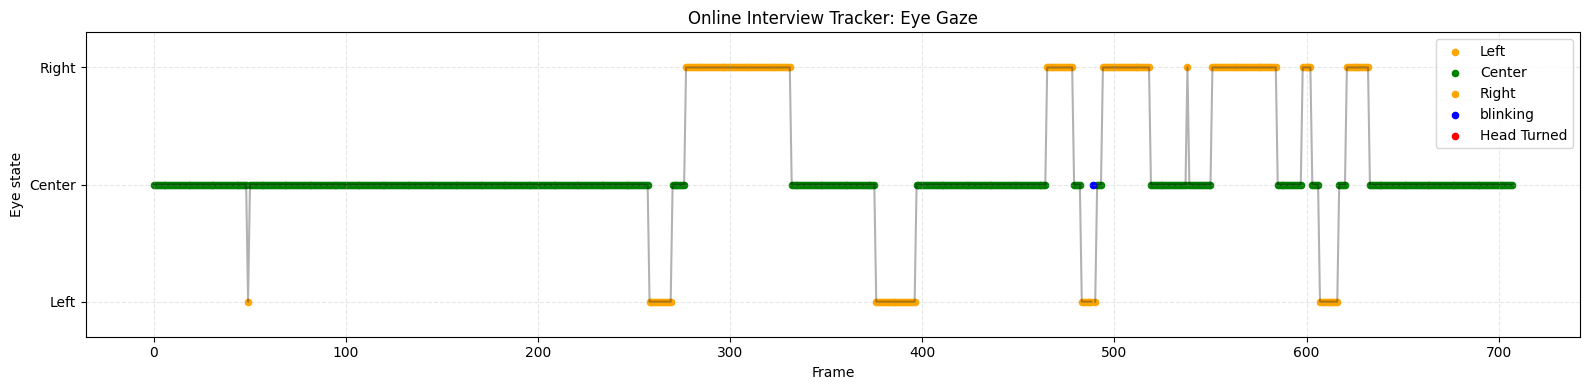

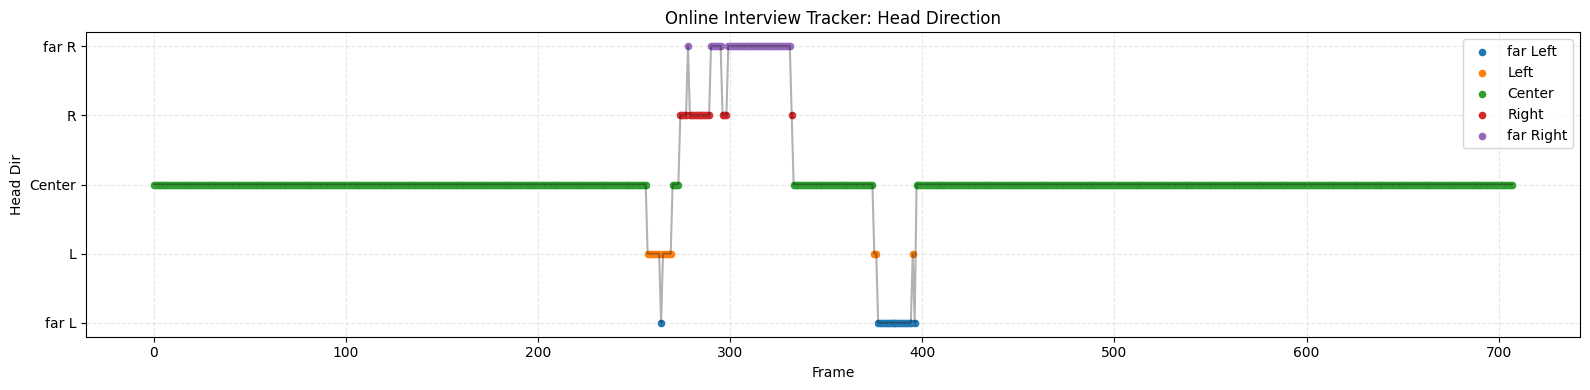

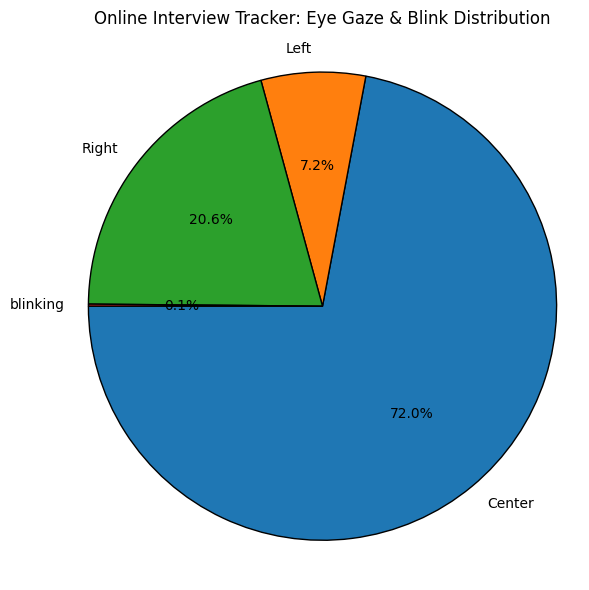

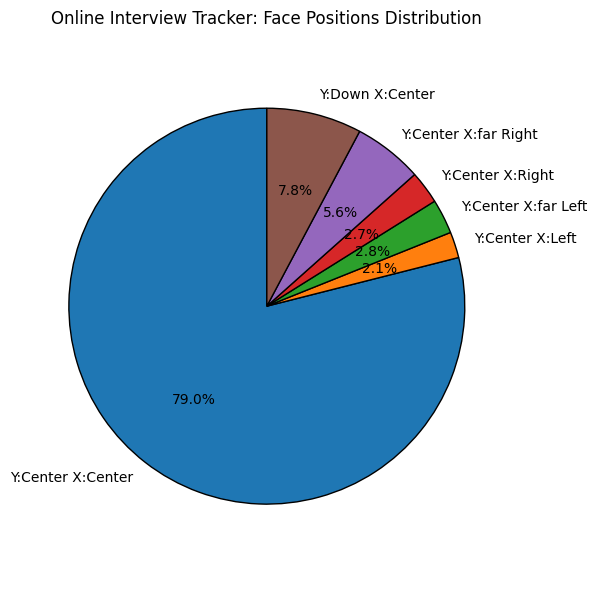

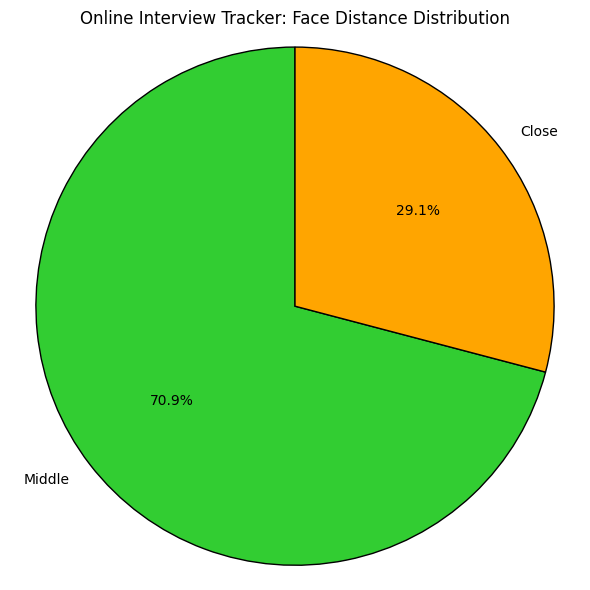

In [25]:
from collections import Counter
visualize_tracking_data(
    eye_hist=eyes_hist,
    head_dir_hist=dir_hist,
#    pos_hist=pos_hist,
    depth_hist=depth_hist,
    title_prefix="Online Interview Tracker")
